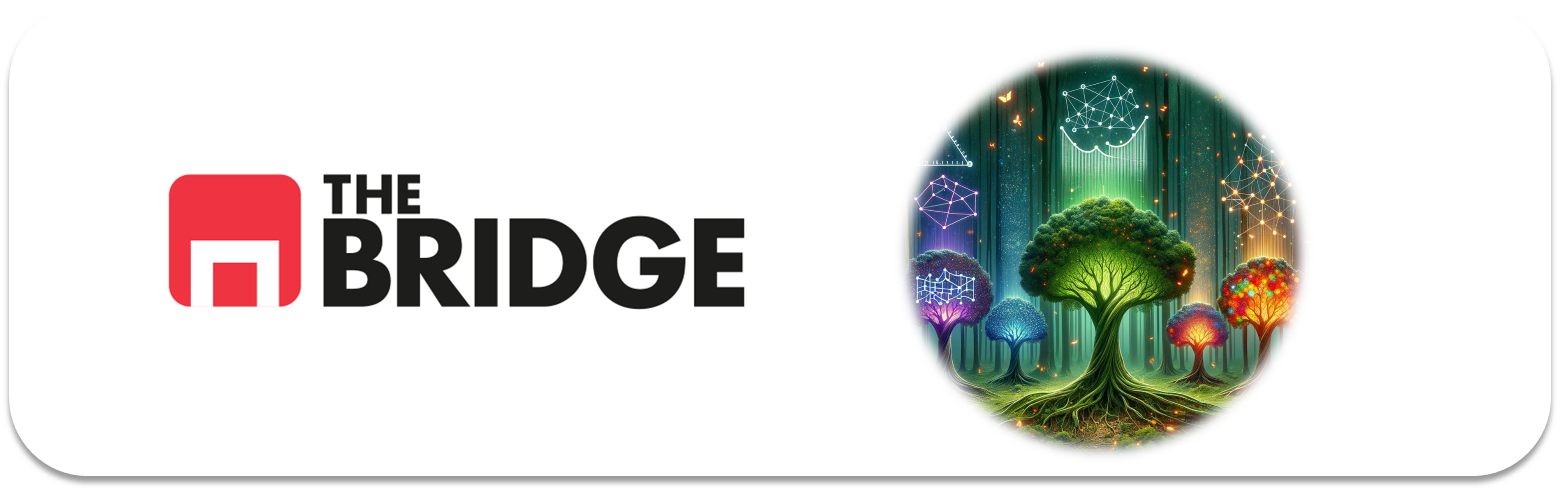

## PRACTICA OBLIGATORIA: **Arboles de Decisión y Ajuste de hiperparámetros**

* La práctica obligatoria de esta unidad consiste en encontrar el mejor modelo para resolver un problema de predicción de si los destinatarios de una campaña de marketing adquirirán un producto concreto. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [229]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import ElasticNet

### Descripción

En el directorio data encontrarás un dataset que contiene datos relacionados con campañas de marketing directo de una institución bancaria portuguesa (es el dataset "Bank Marketing" de la UCI Machine Learning Repository). Los datos se recopilaron de campañas de marketing telefónico, donde el objetivo principal era predecir si el cliente se suscribiría a un depósito a plazo.

La práctica consiste en completar el proceso de creación de un modelo basado en árboles de decisión que permita predecir si un cliente (dadas unas características similares a las del dataset) "comprará" el depósito a plazo. Sigue los pasos necesarios de un proceso de ML para crear el modelo, optimizar sus hiperparámetros, comparar los resultados de esa optimización con una regresión logística (sin optimizar, con sus hiperparámetros por defecto) y finalmente evaluarlo contra test y hacer una pequeña valoración del resultado obtenido.

Tendrás que hacer la limpieza, split, minieda, selección, tratamiento, primeros entrenamientos, optimización, comparación y evaluación según tu mejor criterio. Eso sí, es obligatorio:
- Identificar el target y analizar su distribución
- Realizar una optimización de hiperparámetros, escogiendo un grid medianemante razonado
- Comparar con el modelo baseline
- Evaluar contra test

AYUDA: La dirección del banco nos proporciona estas notas (en inglés):

 
   **bank client data:**  
   1 - age (numeric)  
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services")   
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)  
   4 - education (categorical: "unknown","secondary","primary","tertiary")  
   5 - default: has credit in default? (binary: "yes","no")  
   6 - balance: average yearly balance, in euros (numeric)   
   7 - housing: has housing loan? (binary: "yes","no")  
   8 - loan: has personal loan? (binary: "yes","no")   

   **related with the last contact of the current campaign:**  
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular")   
  10 - day: last contact day of the month (numeric)  
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")  
  12 - duration: last contact duration, in seconds (numeric)    

   **other attributes:**  
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)  
  15 - previous: number of contacts performed before this campaign and for this client (numeric)  
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  

In [230]:
df = pd.read_csv("./data/bank-full.csv", sep = ";")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [231]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [232]:
target = "y"

In [233]:
missings = df['job'].value_counts()["unknown"]
print((missings/len(df['job']))*100)

0.6370131162770122


In [234]:
missings = df['education'].value_counts()["unknown"]
print((missings/len(df['education']))*100)

4.1074074893278185


In [235]:
missings = df['contact'].value_counts()["unknown"]
print((missings/len(df['contact']))*100)

28.798301298356595


In [236]:
missings = df['poutcome'].value_counts()["unknown"]
print((missings/len(df['poutcome']))*100)

81.74780473778506


In [237]:
df.contact.value_counts()

contact
cellular     29285
unknown      13020
telephone     2906
Name: count, dtype: int64

In [238]:
df.poutcome.value_counts()

poutcome
unknown    36959
failure     4901
other       1840
success     1511
Name: count, dtype: int64

### Train / test

In [239]:
train_set, test_set = train_test_split(df, test_size = 0.2, random_state = 42)

### Mini eda

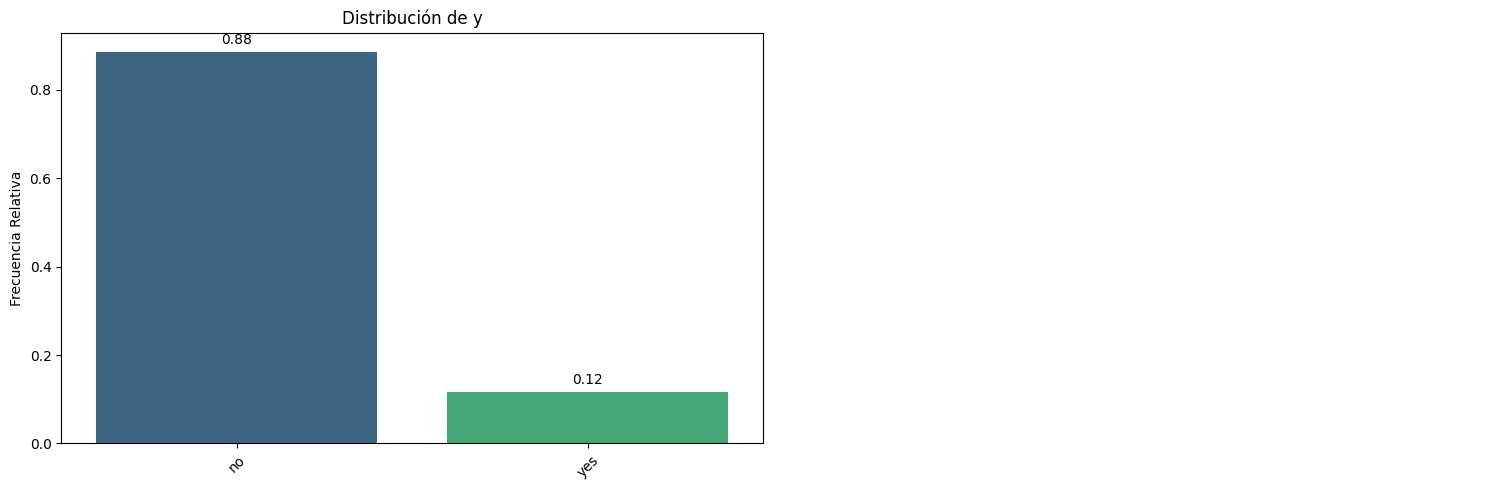

In [240]:
bt.pinta_distribucion_categoricas(train_set, [target], relativa = True, mostrar_valores = True)

In [241]:
features_cat = ['job','marital','education','default','housing','loan','contact','month','poutcome']
features_num = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

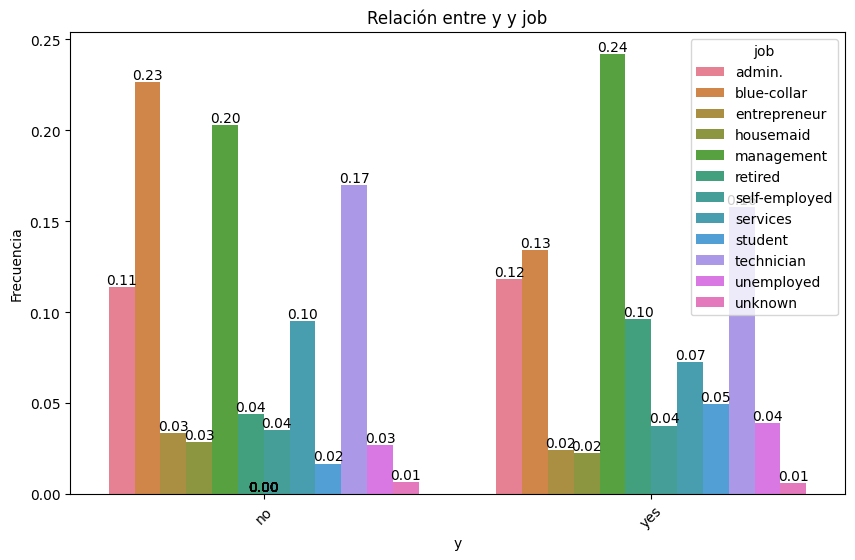

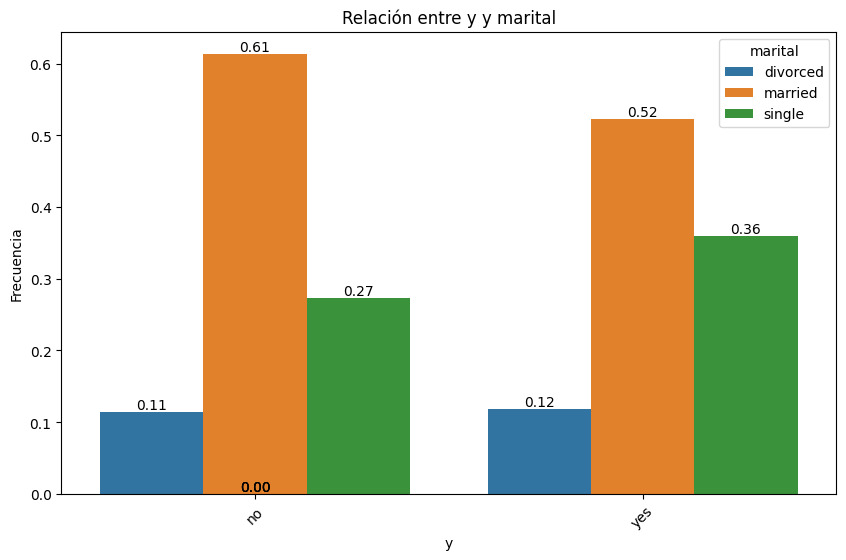

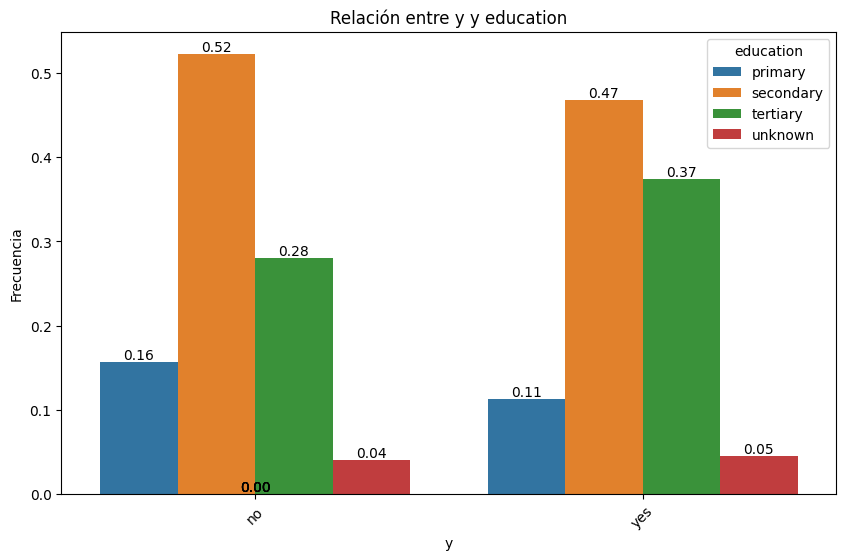

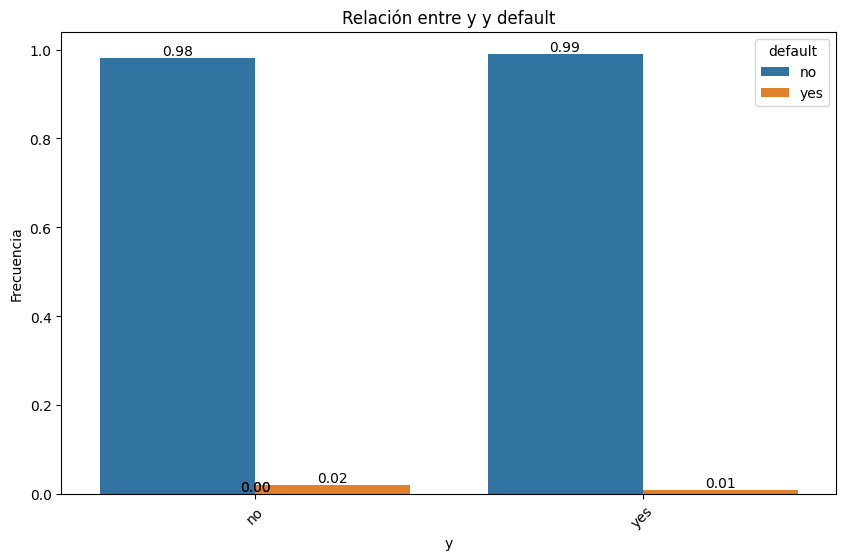

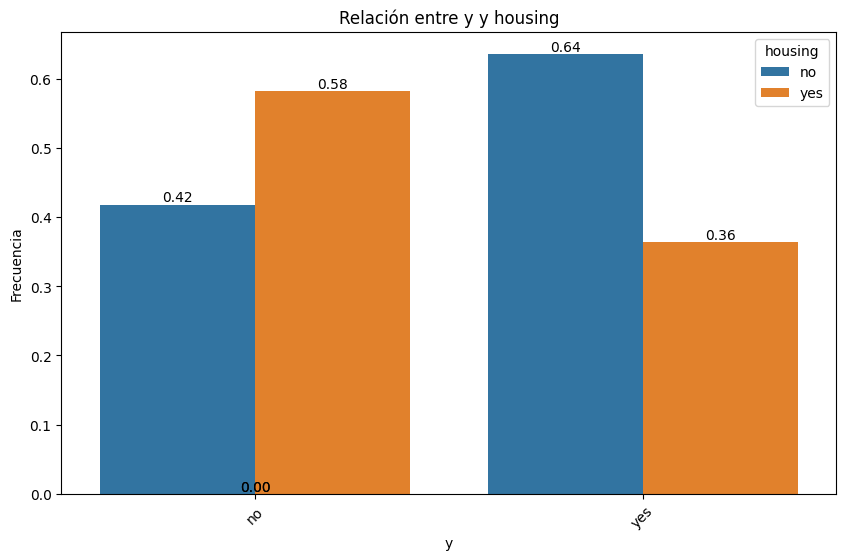

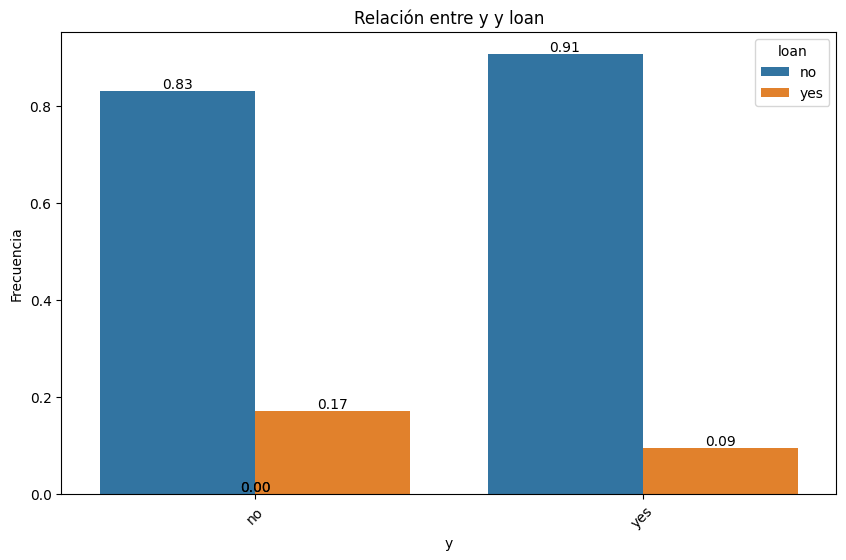

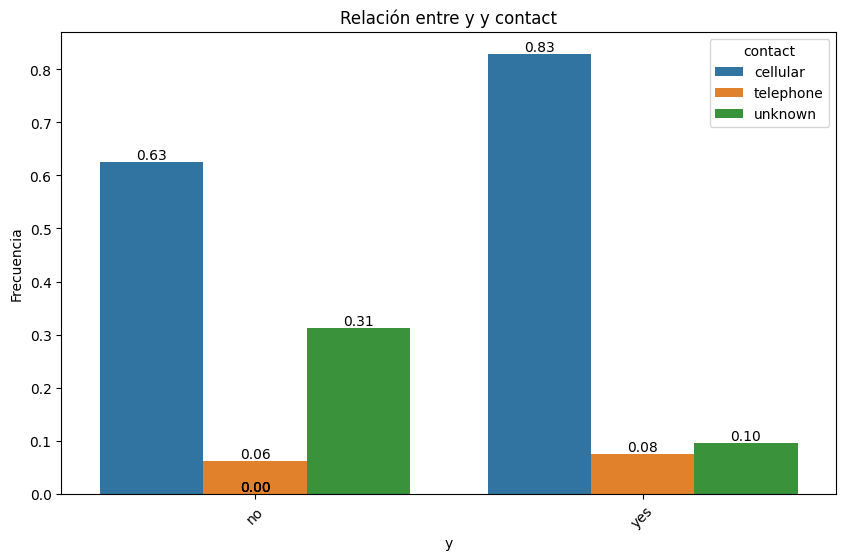

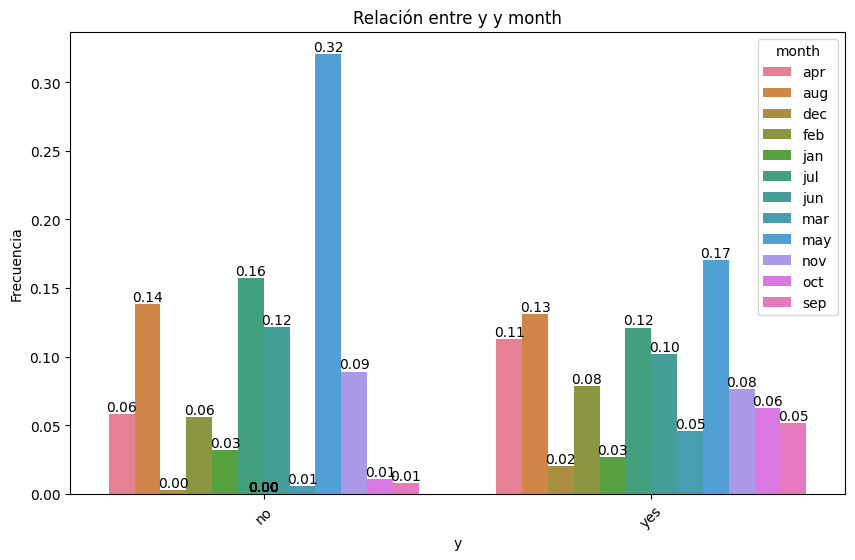

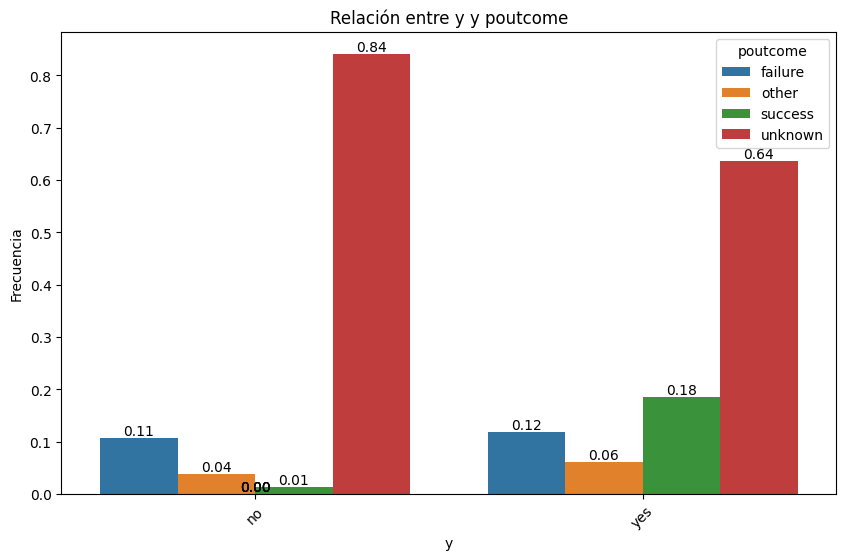

In [242]:
for col in features_cat:
    bt.plot_categorical_relationship_fin(train_set, target, col, relative_freq = True, show_values = True)

- Housing me destaca mucho la diferencia

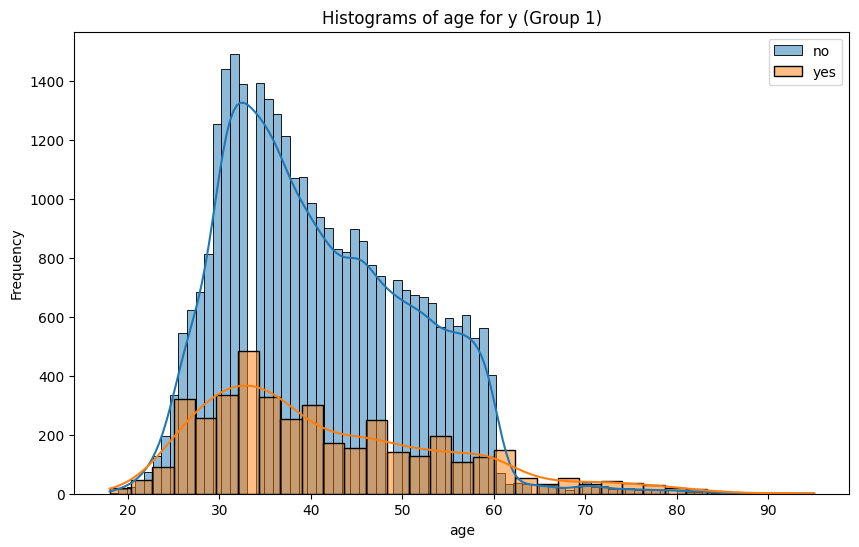

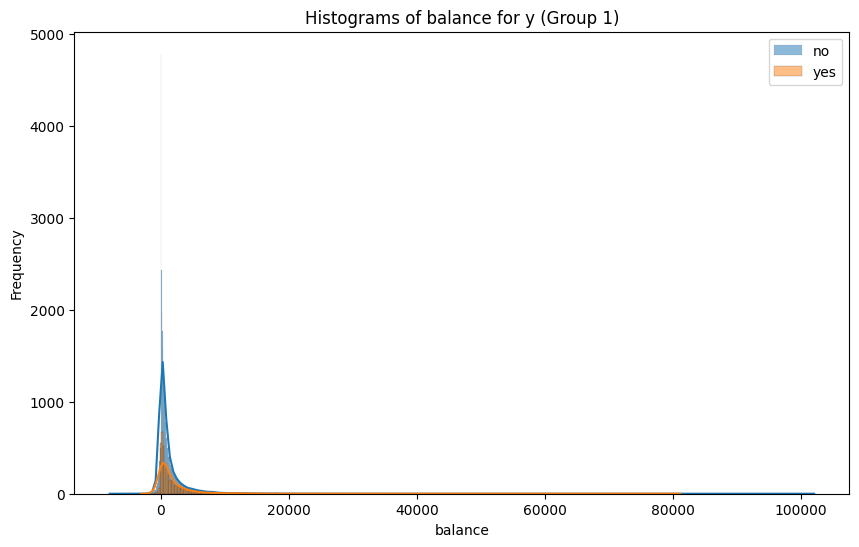

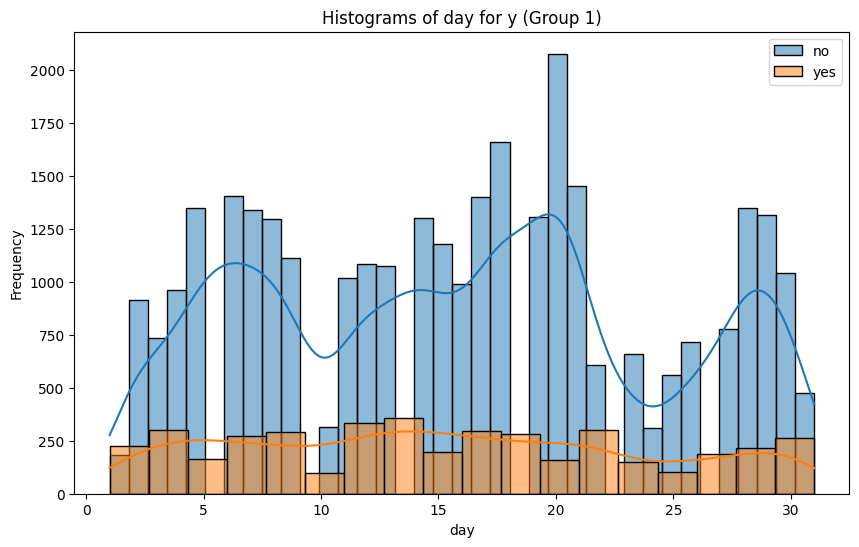

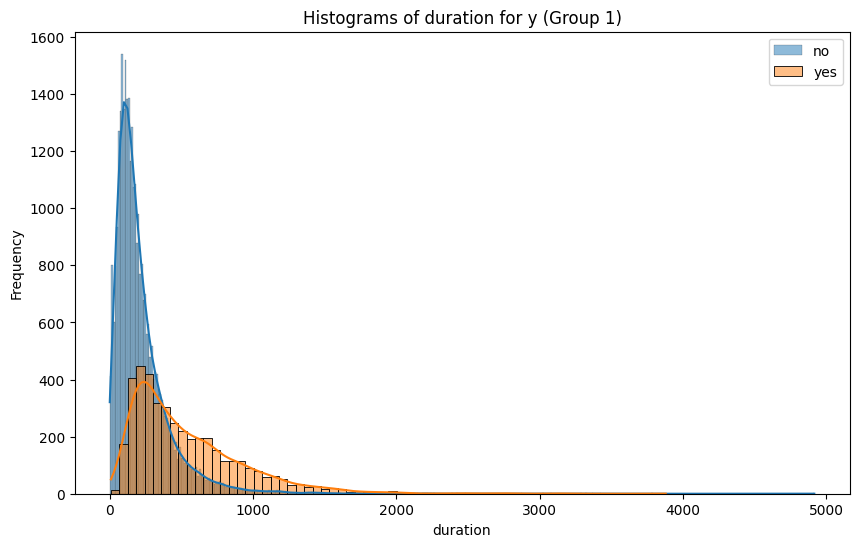

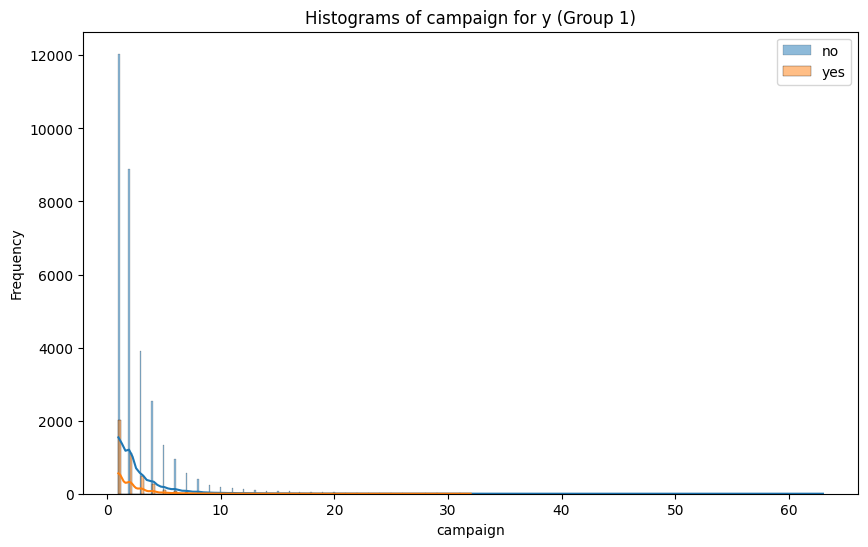

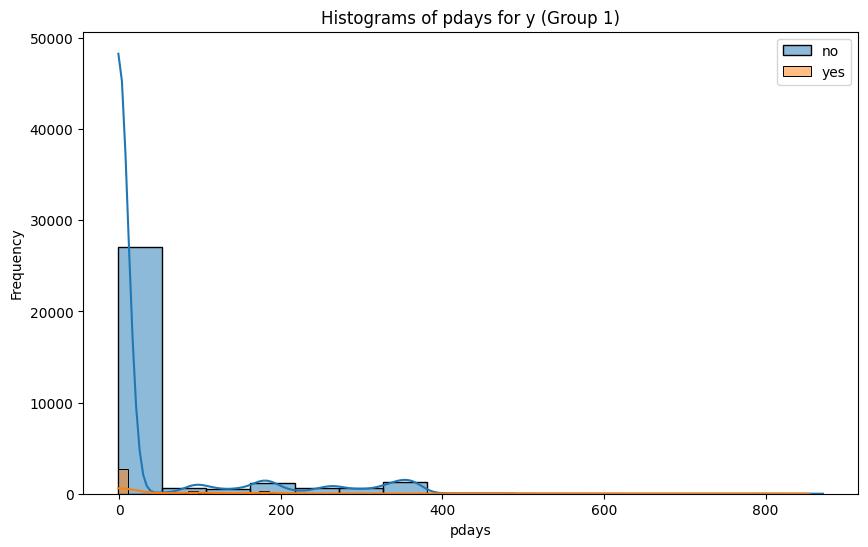

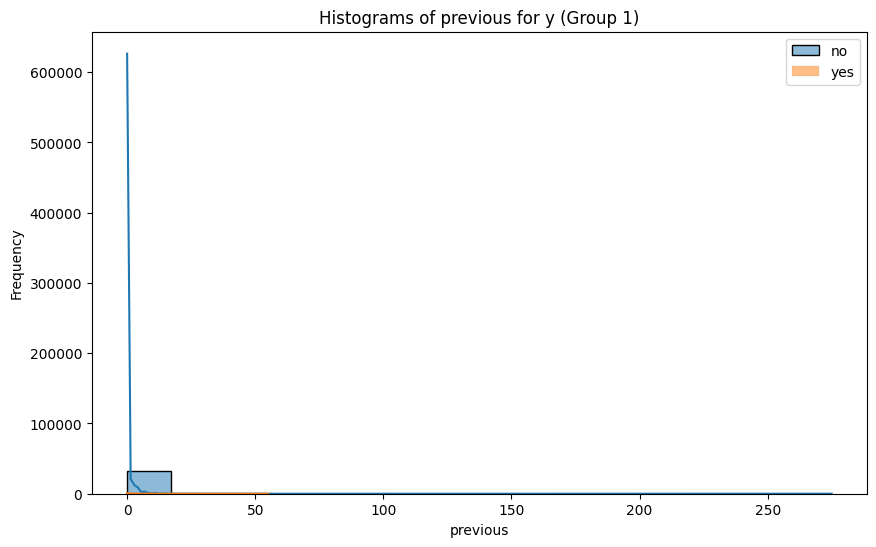

In [243]:
for col in features_num:
    bt.plot_grouped_histograms(train_set, cat_col= target, num_col = col, group_size = 2)

- pdays no nos da información, previous tampoco

In [244]:
# Me quedo con las variables que considero más útiles
features_num = ["age","day","duration","pdays"]
features_cat = ["job","housing","contact","poutcome"]

- Hace falta tratar las variables

In [245]:
train_set["housing"] = train_set["housing"] == "yes"
train_set["loan"] = train_set["loan"] == "yes"
features_cat.remove("housing")


In [246]:
test_set["housing"] = test_set["housing"] == "yes"
test_set["loan"] = test_set["loan"] == "yes"

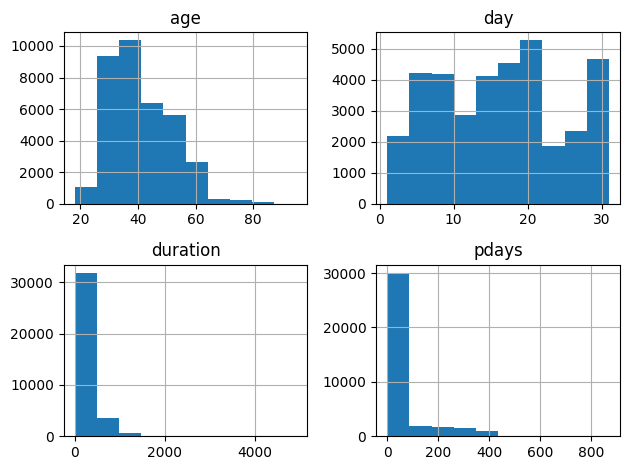

In [247]:
train_set[features_num].hist()
plt.tight_layout()

- Hay que transformar duration y pdays

In [248]:
train_set["duration"] = np.sqrt(train_set["duration"])
train_set["pdays"] = np.sqrt(train_set["duration"])

In [249]:
test_set["duration"] = np.sqrt(test_set["duration"])
test_set["pdays"] = np.sqrt(test_set["duration"])

In [250]:
train_set[features_num]

,age,day,duration,pdays
3344,41,15,8.485281,2.912951
17965,49,30,16.401219,4.049842
18299,42,31,11.401754,3.376648
10221,37,11,19.364917,4.400559
32192,56,15,16.248077,4.030890
...,...,...,...,...
11284,44,18,45.749317,6.763824
44732,23,8,14.491377,3.806754
38158,34,15,15.459625,3.931873
860,33,7,10.535654,3.245867


- Ahora tratamos pdays

In [251]:
def asignar_valor(x):
    if x == -1:
        return 0
    else:
        return 1

In [252]:
df['contactado'] = df['pdays'].apply(asignar_valor)

In [253]:
df['contactado'].value_counts(True)

contactado
0    0.817367
1    0.182633
Name: proportion, dtype: float64

In [254]:
train_set['contactado'] = df['pdays'].apply(asignar_valor)
test_set['contactado'] = df['pdays'].apply(asignar_valor)

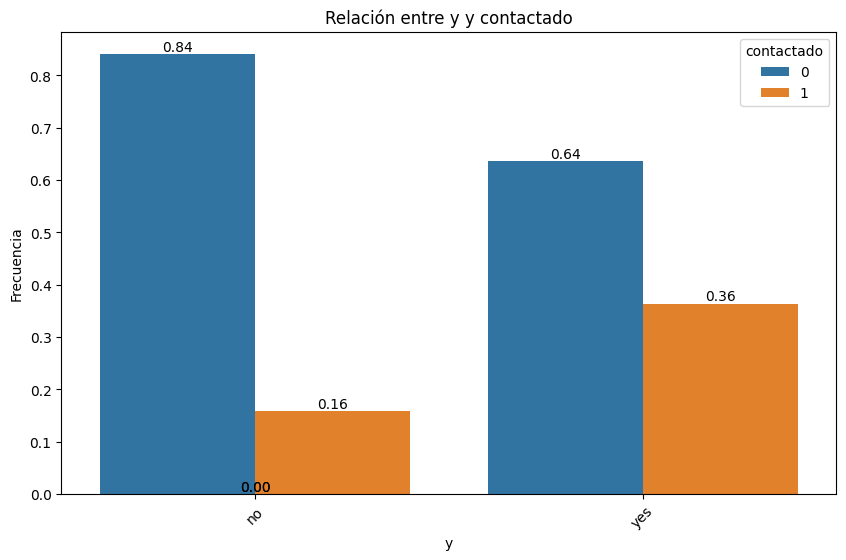

In [255]:
bt.plot_categorical_relationship_fin(train_set, target, "contactado", relative_freq= True, show_values= True)

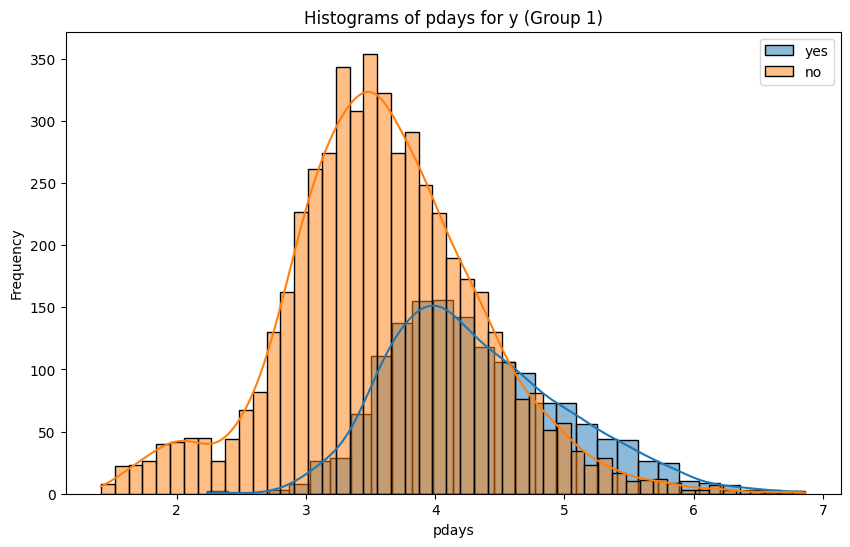

In [256]:
bt.plot_grouped_histograms(train_set[train_set.contactado == 1], cat_col= target, num_col= "pdays", group_size= 2)

In [257]:
features_cat.append("contactado")

### Estandarización

In [258]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_set[features_num] = scaler.fit_transform(train_set[features_num])
test_set[features_num] = scaler.transform(test_set[features_num])

## Árbol

In [259]:
train_set[features_cat].head()

,job,contact,poutcome,contactado
3344,blue-collar,unknown,unknown,0
17965,technician,cellular,unknown,0
18299,admin.,cellular,unknown,0
10221,management,unknown,unknown,0
32192,blue-collar,cellular,unknown,0


In [260]:
train_set = pd.get_dummies(train_set, columns = features_cat, dtype = int)
test_set = pd.get_dummies(test_set, columns = features_cat, dtype = int)

In [261]:
train_set.columns

Index(['age', 'marital', 'education', 'default', 'balance', 'housing', 'loan',
       'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'y',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'contact_cellular', 'contact_telephone', 'contact_unknown',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown', 'contactado_0', 'contactado_1'],
      dtype='object')

In [262]:
features_cat_encoded = ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'contact_cellular', 'contact_telephone', 'contact_unknown',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown', 'contactado_0', 'contactado_1']

In [263]:
X_train = train_set[features_cat_encoded + features_num].copy()
y_train = train_set[target]
X_test = test_set[features_cat_encoded + features_num].copy()
y_test = test_set[target]

In [264]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

lr_clf = LogisticRegression(max_iter = 1000)

In [265]:
tree_clf = DecisionTreeClassifier(random_state = 42)

lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [267]:
print(classification_report(y_test, lr_clf.predict(X_test)))

              precision    recall  f1-score   support

          no       0.91      0.98      0.94      7952
         yes       0.65      0.32      0.42      1091

    accuracy                           0.90      9043
   macro avg       0.78      0.65      0.68      9043
weighted avg       0.88      0.90      0.88      9043



- Uso GridSearchCV para ser más exhaustivo con la búsqueda (en vez de RandomizedSearchCV)
- Investigando con chatgpt me ha dicho que balanced_accuracy sería la mejor opción

In [322]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth": [1,2,10],
    "min_samples_leaf": [1,10,20,100],
    "class_weight": ["balanced", None],
}

tree_grid = GridSearchCV(tree_clf,
                    param_grid,
                    cv = 5,
                    scoring = "balanced_accuracy" 
)
tree_grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': [1, 2, 10],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 10, 20, 100]},
             scoring='balanced_accuracy')

In [323]:
tree_grid.best_params_

{'class_weight': 'balanced',
 'max_depth': 10,
 'max_features': None,
 'min_samples_leaf': 100}

In [324]:
tree_grid.best_score_

0.8067505653898989

In [325]:
tree_grid.best_estimator_.score(X_test, y_test)

0.7810461130155921

In [326]:
y_pred = tree_grid.best_estimator_.predict(X_test)

In [327]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          no       0.97      0.77      0.86      7952
         yes       0.34      0.84      0.48      1091

    accuracy                           0.78      9043
   macro avg       0.65      0.80      0.67      9043
weighted avg       0.90      0.78      0.82      9043



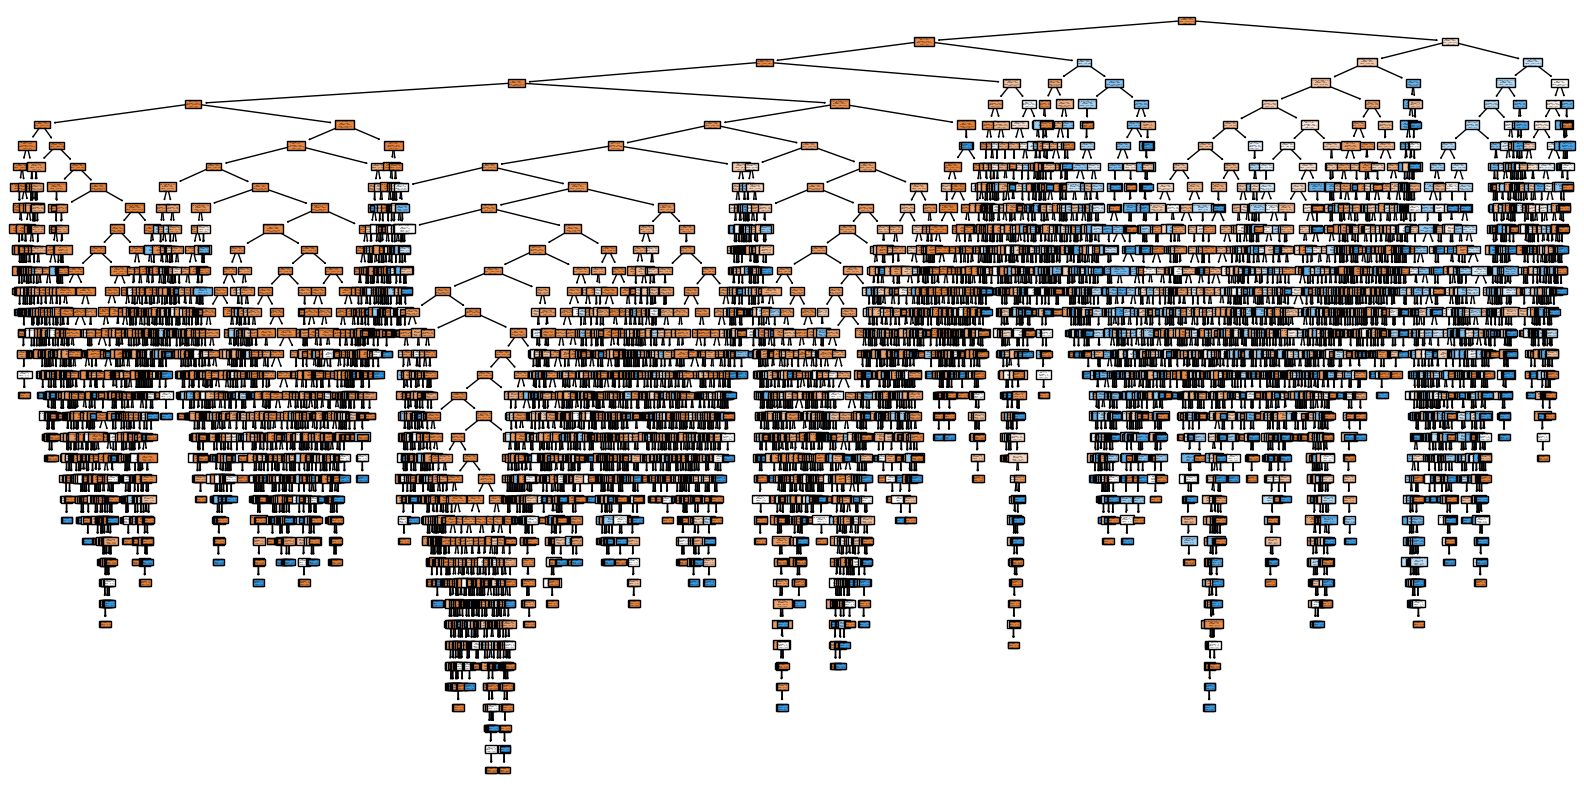

In [329]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

tree_clf.fit(X_train, y_train)

plt.figure(figsize=(20, 10))
plot_tree(tree_clf, filled=True, feature_names=X_train.columns, class_names=True)
plt.show()

- No es legible pero me salen buenos parámetros así que me quedo a la espera de la clase